In [2]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

In [3]:
# Load dataset
exp_name = 'convective_coupling/aquaplanet/d5_sphum'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa
rh_critical = namelist['qe_moist_convection_nml']['rhbm']       # Critical relative humidity used in convection scheme.

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

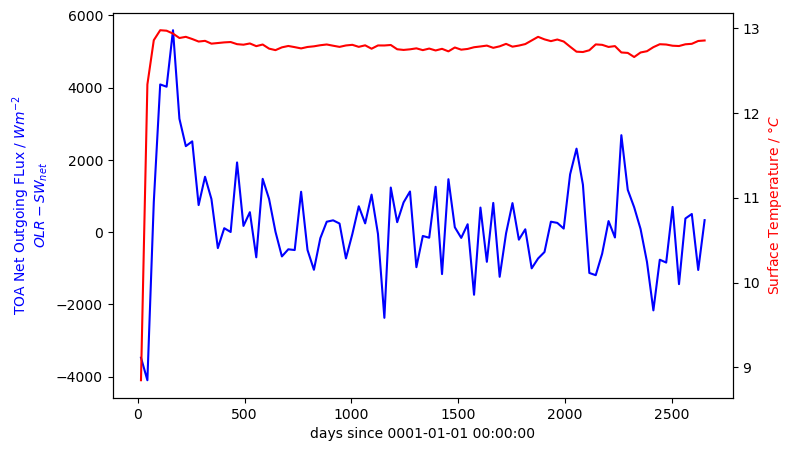

In [4]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(8, 5))
# 101325 is the default reference pressure used by Isca if not set in the constants_nml module
# isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau*(p_full/101325)**4)), ds.temp_2m, ax)
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau), ds.temp_2m, ax)
# ax.set_ylim([-2000, 2000]);

## Specific humidity vs Saturation
See how the specific humidity computed by *Isca* compares to the saturation specific humidity.

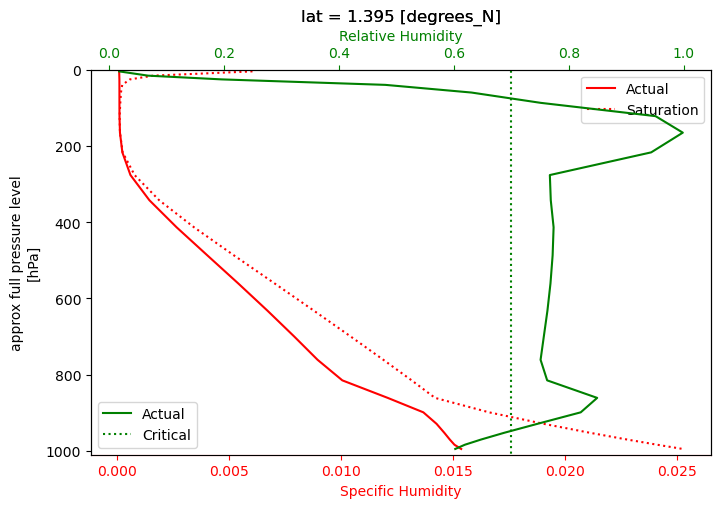

In [30]:
# Take time and zonal mean
# Use all data after 3 years, as clearly converged from the above spin up plot
ds_use = ds.sel(time=slice(360*3, np.inf)).mean(dim=['lon', 'time'])
ds_tropics = ds_use.sel(lat=[0],method='nearest')

fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.xaxis.label.set_color('r')
ax.spines['bottom'].set_color('red')
ax.tick_params(axis='x', colors='r')
ds_tropics.sphum.plot(y='pfull', yincrease=False, color='r', ax=ax, label='Actual');
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_tropics.temp), ds_tropics.pfull * 100)
ax2 = ax.twiny()
ax2.xaxis.label.set_color('g')
ax2.tick_params(axis='x', colors='g')
ax2.set_xlabel('Relative Humidity')
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
sphum_sat.plot(y='pfull', yincrease=False, ax=ax, color='r', linestyle=':', label='Saturation');

rh = rh_from_sphum(ds_tropics.sphum, ds_tropics.temp, ds_tropics.temp.pfull*100)/100
rh.plot(y='pfull', yincrease=False, ax=ax2, color='g', label='Actual');
rh2 = ds_tropics.sphum / sphum_sat   # T`his is not quite correct formula but gives basically the same result
ax.legend()
ax2.set_xlabel('Relative Humidity');
ax2.vlines(rh_critical, -100, 1100, color='g', linestyle=':', label='Critical')
ax2.legend()
plt.ylim([1010,0])
ax.set_xlabel('Specific Humidity');

From the above plot, we see that near the surface, the specific humidity, $q$, is well below the saturation specific humidity, $q_s$ giving a low relative humidity, $r$.

Then in the free troposphere, $r$, settles to a constant level just above the critical value of 0.7 specified in the `qe_moist_convection_nml` namelist through the option `rhbm`.

In [42]:
pressure_ft = 700  # pressure level of free troposphere in hPa
ds_ft = ds_use.sel(pfull=pressure_ft, method='nearest')

mse_2m = moist_static_energy(ds_use.temp_2m, ds_use.sphum_2m, 2)
mse_ft = moist_static_energy(ds_ft.temp, ds_ft.sphum, ds_ft.height)

mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_ft.temp), ds_ft.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_ft_sat = moist_static_energy(ds_ft.temp, sphum_sat, ds_ft.height)

mix_ratio_rh_crit = mixing_ratio_from_partial_pressure(rh_critical * saturation_vapor_pressure(ds_ft.temp), ds_ft.pfull * 100)
sphum_rh_crit = mix_ratio_rh_crit/(1+mix_ratio_rh_crit)
mse_ft_rh_crit = moist_static_energy(ds_ft.temp, sphum_rh_crit, ds_ft.height)

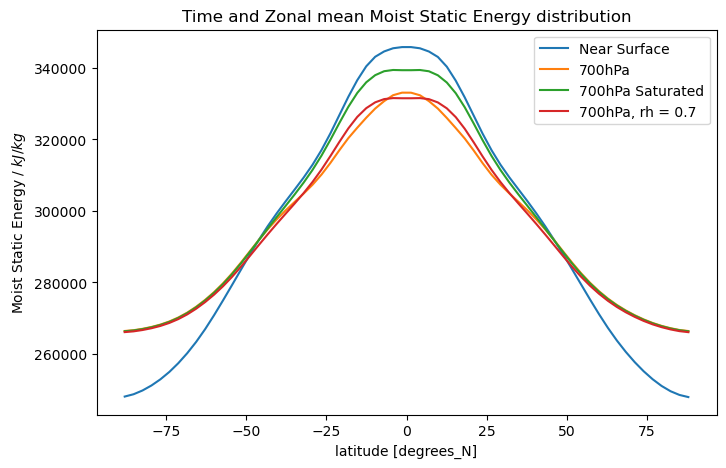

In [44]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_2m.plot.line(ax=ax, add_legend=False, label="Near Surface")
mse_ft.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa")
mse_ft_sat.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa Saturated")
mse_ft_rh_crit.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa, rh = {rh_critical}")
ax.legend();
ax.set_ylabel('Moist Static Energy / $kJ/kg$');
ax.set_title('Time and Zonal mean Moist Static Energy distribution');